In [38]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

In [2]:
using Plots

# grid for evaluation
x = range(-4,4,length=401)
y = copy(x)
z = x .+ im*y';

# unit circle
θ = range(0,2π,length=101)
zc = exp.(im*θ[1:end-1]);

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


### A few helper routines

In [3]:
strength(v::Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}) = v.S
strength(v::Vector{T}) where {T<:PotentialFlow.Points.Point} = map(vj -> strength(vj),v) 

strength (generic function with 2 methods)

In [4]:
# Create a set of n random point vortices in the range [-2,2]x[-2,2], all of which are outside the unit circle
function create_random_vortices(n::Integer;σ=0.01)
    z = ComplexF64[]
    Γ = Float64[]
    num = 0
    while num < n
        ztest = 4.0(rand(ComplexF64)-0.5-im*0.5)
        Γtest = 2.0(rand(Float64)-0.5)
        if (abs2(ztest)>1.0)
            push!(z,ztest)
            push!(Γ,Γtest)
            num += 1
        end
    end
    return Vortex.Blob.(z,Γ,σ)
end

create_random_vortices (generic function with 1 method)

### Define the functions that comprise the pressure and its gradients

In [5]:
flag = 1
Fvd(z,zv) = -0.5im/π*log(z-zv)
Fvi(z,zv) = -flag*0.5im/π*(-log(z-1/conj(zv)) + log(z))
Fv(z,zv) = Fvd(z,zv) + Fvi(z,zv) 
wvd(z,zv;ϵ=0.01) = -0.5im/π*conj(z-zv)/(abs2(z-zv)+ϵ^2)
wvi(z,zv) = -flag*0.5im/π*(-1/(z-1/conj(zv)) + 1/z)
wv(z,zv;ϵ=0.01) = wvd(z,zv;ϵ=ϵ) + wvi(z,zv)

dwvddz(z,zv;ϵ=0.01) = 0.5im/π/(z-zv)^2
dwvidz(z,zv) = -flag*0.5im/π*(1/(z-1/conj(zv))^2-1/z^2)
dwvdz(z,zv;ϵ=0.01) = dwvddz(z,zv;ϵ=ϵ) + dwvidz(z,zv)
dwvddzv(z,zv;ϵ=0.01) = -dwvddz(z,zv;ϵ=ϵ)
dwvidzvstar(z,zv) = -flag*0.5im/π/conj(zv)^2/(z-1/conj(zv))^2

dFddzv(z,zv;ϵ=0.01) = -wvd(z,zv;ϵ=ϵ)
dFidzvstar(z,zv) = flag*0.5im/π/conj(zv)^2/(z-1/conj(zv))
dFdzv(z,zv;ϵ=0.01) = dFddzv(z,zv;ϵ=0.01) + conj(dFidzvstar(z,zv))

d2Fddzv2(z,zv;ϵ=0.01) = -dwvddz(z,zv;ϵ=ϵ)
d2Fidzvstar2(z,zv) = -flag*0.5im/π/conj(zv)^3/(z-1/conj(zv))*(2 + 1/conj(zv)/(z-1/conj(zv)))
d2Fdzv2(z,zv;ϵ=0.01) = d2Fddzv2(z,zv;ϵ=0.01) + conj(d2Fidzvstar2(z,zv))


P(z,zv;kwargs...) = -0.5*abs2(wv(z,zv;kwargs...)) - real(dFdzv(z,zv;kwargs...)*conj(wvi(zv,zv)))
Π(z,zvj,zvk;kwargs...) = -real(wv(z,zvj;kwargs...)*conj(wv(z,zvk;kwargs...))) -
                           real(dFdzv(z,zvj;kwargs...)*conj(wv(zvj,zvk;kwargs...))) -
                           real(dFdzv(z,zvk;kwargs...)*conj(wv(zvk,zvj;kwargs...)))

dPdzv(z,zv;kwargs...) = -0.5*(dwvddzv(z,zv;kwargs...)*conj(wv(z,zv;kwargs...)) + wv(z,zv;kwargs...)*conj(dwvidzvstar(z,zv))) -
                        0.5*(d2Fdzv2(z,zv;kwargs...)*conj(wvi(zv,zv)) + dFdzv(z,zv;kwargs...)*conj(dwvidzvstar(zv,zv))) -
                        0.5*(conj(dFdzv(z,zv;kwargs...))*dwvidz(zv,zv))

dΠdzvl(z,zvl,zvk;kwargs...) = -0.5*(dwvddzv(z,zvl;kwargs...)*conj(wv(z,zvk;kwargs...)) + conj(dwvidzvstar(z,zvl))*wv(z,zvk;kwargs...)) -
                               0.5*(d2Fdzv2(z,zvl;kwargs...)*conj(wv(zvl,zvk;kwargs...)) + conj(dFdzv(z,zvl;kwargs...))*dwvdz(zvl,zvk;kwargs...)) -
                               0.5*(dFdzv(z,zvk;kwargs...)*conj(dwvidzvstar(zvk,zvl)) + conj(dFdzv(z,zvk;kwargs...))*dwvddzv(zvk,zvl;kwargs...))

dΠdzvl (generic function with 1 method)

### Define the complex potential and velocity

In [15]:
for f in [:F,:w]

    vd = Symbol(f,"vd")
    vi = Symbol(f,"vi")

    @eval function $f(z,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        out = complex(0)
        for vj in v
            zj = Elements.position(vj)
            out += strength(vj)*($vd(z,zj;kwargs...) + $vi(z,zj;kwargs...))
        end
        return out
    end
    
    @eval $f(z::AbstractArray,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> $f(zj,v;kwargs...),z)
end

In [16]:
vort = create_random_vortices(4; σ=0.01)

4-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(-1.4902628912170046 - 0.05624159220468794im, 0.1882741408065005, 0.01)
 Vortex.Blob(1.747449725221066 - 0.480668884329444im, -0.5597849808607926, 0.01)
 Vortex.Blob(-0.14940948798058695 + 1.0344525276958692im, -0.849633101165649, 0.01)
 Vortex.Blob(-1.8311918617898266 + 1.0426710243604242im, 0.5352271282603773, 0.01)

In [17]:
# Rate of change of vortex positions
@time dzvdt = conj.(w(Elements.position(vort),vort));

  0.112274 seconds (83.48 k allocations: 4.985 MiB, 99.79% compilation time)


### Define the pressure and its gradients

Note that $\mathrm{d}p/\mathrm{d}z^* = (\mathrm{d}p/\mathrm{d}z)^*$. To obtain the gradient of pressure with respect to the $x$ or $y$ position of vortex $l$, use

$$\frac{\partial p}{\partial x_l} = \frac{\mathrm{d}p}{\mathrm{d}z_l} + \frac{\mathrm{d}p}{\mathrm{d}z^*_l} = 2 \mathrm{Re} \frac{\mathrm{d}p}{\mathrm{d}z_l}$$

and

$$\frac{\partial p}{\partial y_l} = \mathrm{i}\frac{\mathrm{d}p}{\mathrm{d}z_l} - \mathrm{i} \frac{\mathrm{d}p}{\mathrm{d}z^*_l} = -2 \mathrm{Im} \frac{\mathrm{d}p}{\mathrm{d}z_l}$$

In [9]:
function pressure(z,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        out = 0.0
        for (j,vj) in enumerate(v)
            zj,Γj  = Elements.position(vj), strength(vj)
            out += Γj^2*P(z,zj;kwargs...)
            for vk in v[1:j-1]
                zk,Γk  = Elements.position(vk), strength(vk)
                out += Γj*Γk*Π(z,zj,zk;kwargs...)
            end
        end
        return out
end

# Change of pressure with respect to change of strength of vortex l (specified by its index)
function dpdΓv(z,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        zl,Γl  = Elements.position(v[l]), strength(v[l]) 
        out = 2*Γl*P(z,zl;kwargs...)
        for (k,vk) in enumerate(v)
            k == l && continue
            zk,Γk  = Elements.position(vk), strength(vk)
            out += Γk*Π(z,zl,zk;kwargs...)
        end
        return out
end

# Change of pressure with respect to change of position of vortex l (specified by its index)
function dpdzv(z,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        zl,Γl  = Elements.position(v[l]), strength(v[l]) 
        out = Γl*dPdzv(z,zl;kwargs...)
        for (k,vk) in enumerate(v)
            k == l && continue
            zk,Γk  = Elements.position(vk), strength(vk)
            out += Γk*dΠdzvl(z,zl,zk;kwargs...)
        end
        return Γl*out
end


pressure(z::AbstractArray,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> pressure(zj,v;kwargs...),z)
dpdzv(z::AbstractArray,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> dpdzv(zj,l,v;kwargs...),z)
dpdΓv(z::AbstractArray,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> dpdΓv(zj,l,v;kwargs...),z)

dpdΓv (generic function with 2 methods)

### Examples

In [10]:
## FD validation

# unit circle
θ = range(0,2π,length=101)
zc = exp.(im*θ[1:end-1]);

zv = 1.5*[exp(im*0), exp(im*π)];
Γv = [1.1; -0.8];

# vort = create_random_vortices(4)
vort = Vortex.Point.(zv, Γv)

# These below are only used for verification purposes
dx = sqrt(eps())#1e-4
vort_x1 = Vortex.Point.(zv .+ [dx,0],Γv)
vort_y1 = Vortex.Point.(zv .+ [im*dx,0],Γv)
vort_Γ1 = Vortex.Point.(zv,Γv.+[dx,0])

p = pressure(zc,vort);
dpdz1 = dpdzv(zc,1,vort);
dpdΓ1 = dpdΓv(zc,1,vort);
dpdz2 = dpdzv(zc,2,vort);

p_x1 = pressure(zc,vort_x1);
p_y1 = pressure(zc,vort_y1);
p_Γ1 = pressure(zc,vort_Γ1);

@show norm((1/dx) * (p_x1 - p) - 2*real.(dpdz1))/norm(2*real.(dpdz1))
@show norm((1/dx) * (p_y1 - p) - (-2)*imag.(dpdz1))/norm(2*imag.(dpdz1))
@show norm((1/dx) * (p_Γ1 - p) - dpdΓ1)/norm(dpdΓ1)

norm((1 / dx) * (p_x1 - p) - 2 * real.(dpdz1)) / norm(2 * real.(dpdz1)) = 0.29755126599503606
norm((1 / dx) * (p_y1 - p) - -2 * imag.(dpdz1)) / norm(2 * imag.(dpdz1)) = 0.2792074696116386
norm((1 / dx) * (p_Γ1 - p) - dpdΓ1) / norm(dpdΓ1) = 8.413335840903506e-9


8.413335840903506e-9

In [21]:
@time dpdz1 = dpdzv(zc,1,vort)

  0.000766 seconds (18.20 k allocations: 565.891 KiB)


100-element Vector{ComplexF64}:
    0.4713687747971483 + 7.535866436307163e-20im
    0.4209691490165957 + 0.16855189876784915im
   0.29900841050297433 + 0.27447310730007307im
   0.16431933218510367 + 0.3007790075099598im
   0.05887940212551128 + 0.27147147923175485im
 -0.006373358506618045 + 0.21950552878232546im
 -0.039054512857632985 + 0.1669748510419763im
  -0.05105961807862369 + 0.12328931086123458im
 -0.051918660521819454 + 0.09019209610294512im
  -0.04763374886775279 + 0.06625728122024648im
  -0.04150022810219179 + 0.04931023498272335im
  -0.03514514555238732 + 0.03738379707261954im
 -0.029279370645054627 + 0.028963400070838505im
                       ⋮
  -0.02927937064505458 - 0.028963400070838453im
  -0.03514514555238724 - 0.03738379707261941im
  -0.04150022810219177 - 0.04931023498272331im
  -0.04763374886775274 - 0.0662572812202463im
  -0.05191866052181941 - 0.09019209610294472im
  -0.05105961807862371 - 0.12328931086123433im
  -0.03905451285763326 - 0.16697485104197568im
 -

In [13]:
(1/dx) * (p_Γ1 - p)

100-element Vector{Float64}:
 -0.37360369600355625
 -0.3494506161659956
 -0.28715124167501926
 -0.2091334369033575
 -0.13549505919218063
 -0.07659812550991774
 -0.0343201223295182
 -0.006211917498148978
  0.011336244526319206
  0.021590970107354224
  0.027040497516281903
  0.02942705573514104
  0.0299156135879457
  ⋮
  0.0299156135879457
  0.029427055502310395
  0.027040497516281903
  0.021590969990938902
  0.011336244497215375
 -0.006211917381733656
 -0.03432012256234884
 -0.07659812597557902
 -0.13549505826085806
 -0.2091334369033575
 -0.28715124167501926
 -0.3494506161659956

In [11]:
(1/dx) * (p_x1 - p)

100-element Vector{Float64}:
  0.7154077738523483
  0.6267394684255123
  0.4142736401408911
  0.18473003432154655
  0.012140446342527866
 -0.08689932432025671
 -0.12878427933901548
 -0.13630854059010744
 -0.12689397737267427
 -0.11100869404617697
 -0.09404241142328829
 -0.07838664925657213
 -0.06487000547349453
  ⋮
 -0.06487000593915582
 -0.0783866501878947
 -0.09404241084121168
 -0.11100869555957615
 -0.1268939774017781
 -0.1363085409393534
 -0.12878428073599935
 -0.08689932385459542
  0.012140451930463314
  0.18473003059625626
  0.4142736494541168
  0.6267394628375769

In [12]:
2*real.(dpdz1)

100-element Vector{Float64}:
  0.9427375495942966
  0.8419382980331914
  0.5980168210059487
  0.32863866437020733
  0.11775880425102256
 -0.01274671701323609
 -0.07810902571526597
 -0.10211923615724738
 -0.10383732104363891
 -0.09526749773550558
 -0.08300045620438358
 -0.07029029110477464
 -0.058558741290109254
  ⋮
 -0.05855874129010916
 -0.07029029110477449
 -0.08300045620438354
 -0.09526749773550548
 -0.10383732104363882
 -0.10211923615724743
 -0.07810902571526653
 -0.012746717013236392
  0.117758804251021
  0.32863866437020345
  0.5980168210059473
  0.841938298033189

In [114]:
zv = 1.5*[exp(im*0), exp(im*π)];
Γv = [1.1; -0.8];

# vort = create_random_vortices(4)
vort = Vortex.Point.(zv, Γv)

# These below are only used for verification purposes
dx = 1e-4
vort_x1 = Vortex.Point.(zv .+ [dx,0],Γv)
vort_y1 = Vortex.Point.(zv .+ [im*dx,0],Γv)
vort_Γ1 = Vortex.Point.(zv,Γv.+[dx,0])

2-element Vector{PotentialFlow.Points.Point{Float64, Float64}}:
 Vortex.Point(1.5 + 0.0im, 1.1001)
 Vortex.Point(-1.5 + 1.8369701987210297e-16im, -0.8)

In [45]:
# Evaluate on the observation points 

ψ = imag.(F(z,vort));
@time p = pressure(z,vort);
dpdz1 = dpdzv(z,1,vort);
dpdΓ1 = dpdΓv(z,1,vort);
dpdz2 = dpdzv(z,2,vort);

# For verification purposes
# p_x1 = pressure(z,vort_x1);
# p_y1 = pressure(z,vort_y1);
# p_Γ1 = pressure(z,vort_Γ1);

  0.647148 seconds (643.21 k allocations: 94.465 MiB, 2.91% gc time)


In [124]:
# Evaluate pressure on the circle
pc = pressure(zc,vort);

In [125]:
plot(real(dpdzv(zc,4,vort)); legend = false)
plot!(imag(dpdzv(zc,4,vort)); legend = false)
plot!(dpdΓv(zc,4,vort); legend = false)

LoadError: BoundsError: attempt to access 2-element Vector{PotentialFlow.Points.Point{Float64, Float64}} at index [4]

In [126]:
@time dpdzv(zc,4,vort)

LoadError: BoundsError: attempt to access 2-element Vector{PotentialFlow.Points.Point{Float64, Float64}} at index [4]

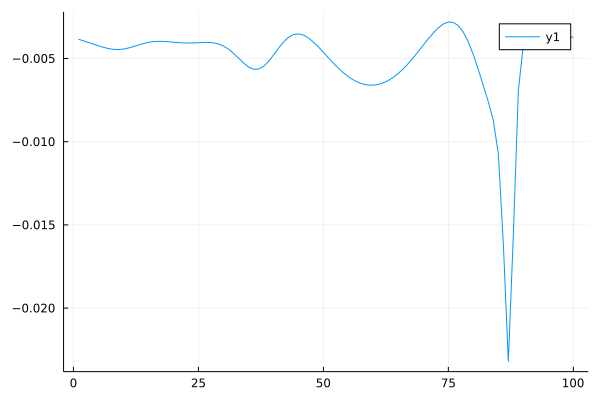

In [31]:
plot(pc)

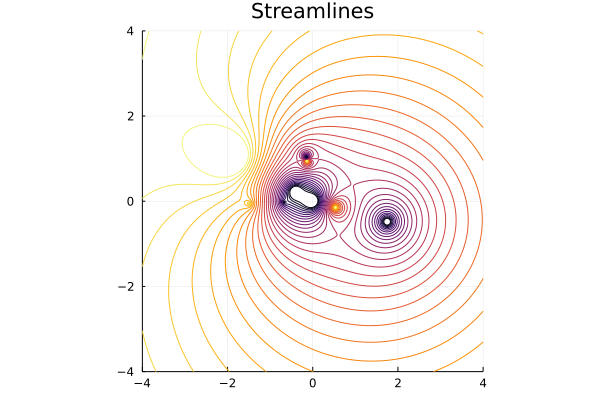

In [46]:
plot(x,y,ψ',ratio=1,levels=range(-0.25,0.25,length=31),clim=(-0.25,0.25))
# plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="Streamlines")

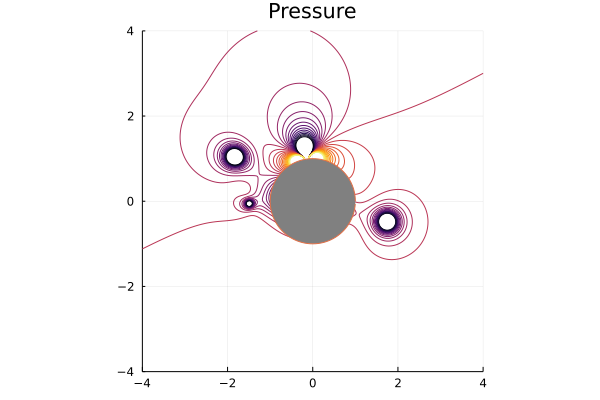

In [47]:
plot(x,y,p',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="Pressure")

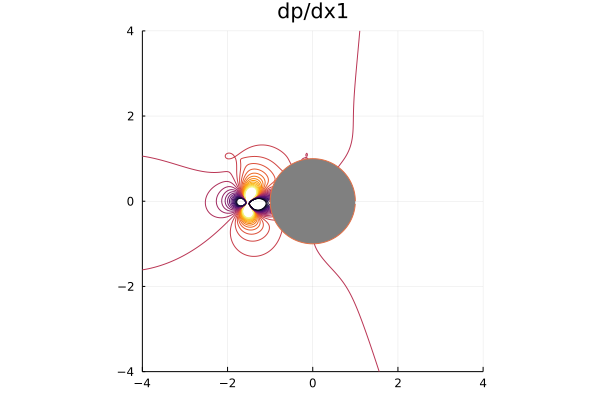

In [48]:
plot(x,y,2*real.(dpdz1)',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="dp/dx1")

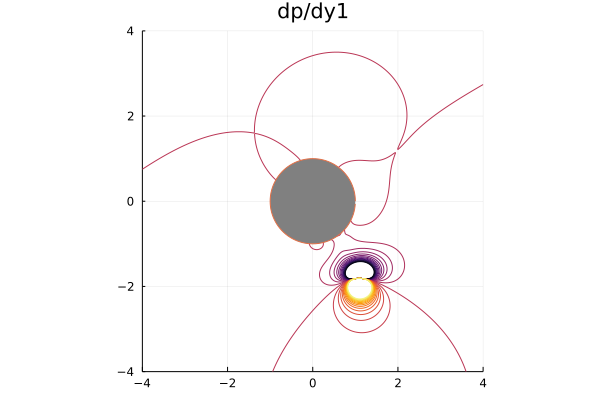

In [27]:
plot(x,y,-2*imag.(dpdz1)',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="dp/dy1")

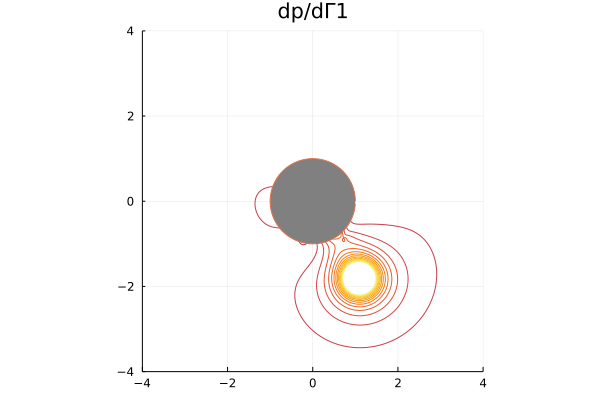

In [28]:
plot(x,y,dpdΓ1',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="dp/dΓ1")

In [29]:
# For verification
#plot(x,y,(p_Γ1.-p)'/dx,ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
#plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
#plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="Pressure")

In [ ]:
### Advection of a collection of point vortices outside a circle

